# Car Fuel Consumption

https://www.kaggle.com/datasets/anderas/car-consume

In [77]:
# Import Libraries

import sys
import numpy as np
import pandas as pd

# Statistical Analysis
from scipy.stats import shapiro
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# Machine Learning (ML) to Fill NaN values for temperature
from sklearn.linear_model import LinearRegression

# ML to split data
from sklearn.model_selection import train_test_split

# ML label encoder
from sklearn.preprocessing import LabelEncoder

# ML to evaluate models
from sklearn.metrics import accuracy_score

# ML Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# ML to search the better parametters
from sklearn.model_selection import GridSearchCV

# ML to store the model
import joblib

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Functions

sys.path.append('../src')
from support import *

In [3]:
# Import Data

measurements_csv = pd.read_csv('../data/measurements.csv')
measurements_xlsx = pd.read_excel('../data/measurements2.xlsx')

### Compare the two sources of data
#### CSV Data

In [4]:
measurements_csv.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 146.0 KB


In [5]:
measurements_csv.head(2)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN


#### XLSX Data

In [6]:
measurements_xlsx.head(2)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN


In [7]:
measurements_xlsx.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 77.6 KB


I will continue the analysis with the XLSX data, because the datatypes are already stablished

### Exploratory Data Analysis (EDA)

- **distance** (km)
- **consume** (L/100km)
- average **speed** (km/h)
- temperature inside: **temp_inside** (°C)
- temperature outside: **temp_outside** (°C)
- anything special that happened: **specials**
- if it was **rain**ing
- if the air condition **AC** was on
- if it was **sun**ny enough that the car felt warm when i started it
- the gas type i was using: **gas_type**

I have also two columns saying how much, **refill liters**, and which gas type, **refill gas**, I was buying. Careful with those. The numbers don't add exactly up, because I note only the rides that occur under certain conditions: If the car was not cooling down enough to have another independent measure from the one before, i don't note it.

In [8]:
df = measurements_xlsx.copy()

#### Fill NaN values

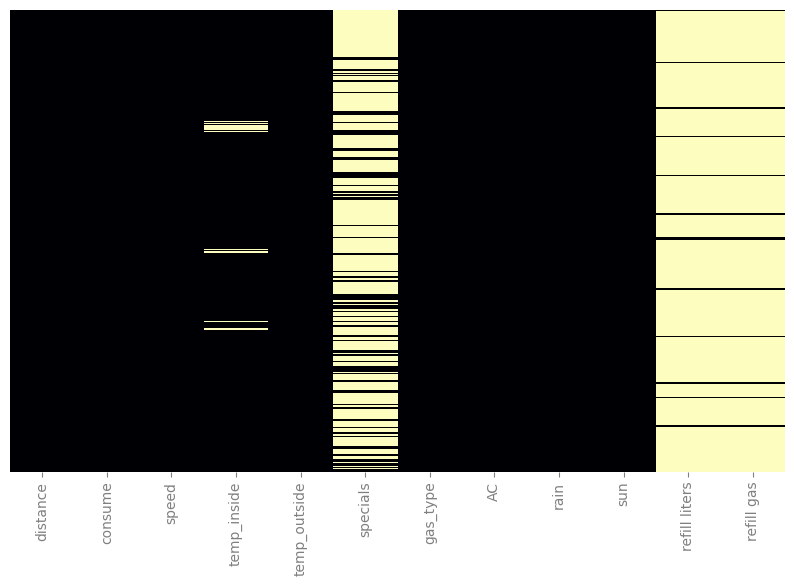

In [9]:
view_nan(df)

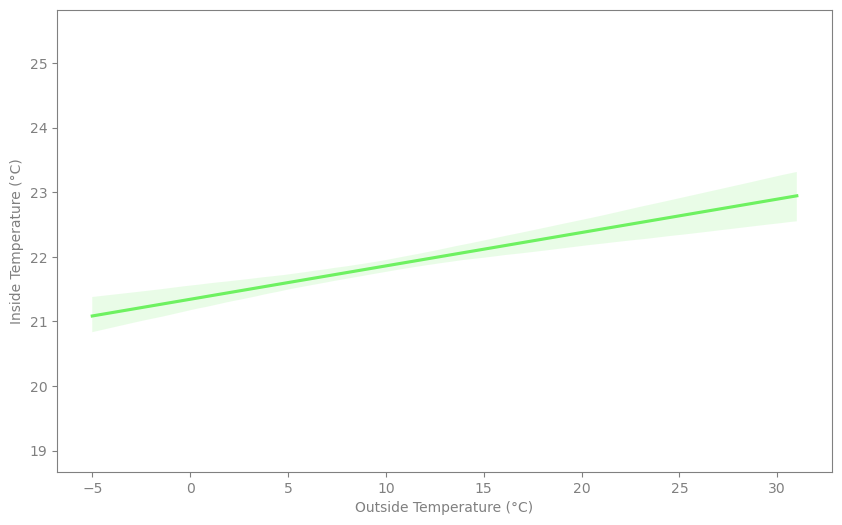

In [10]:
# Plot the temperatures

fig = plt.figure(facecolor = 'none', figsize = (10, 6))

ax = fig.add_subplot(111, facecolor = 'none')

sns.regplot(x = df['temp_outside'],
            y = df['temp_inside'], 
            data = df, 
            scatter = True, 
            scatter_kws={'s': .5, 'alpha': .3}, 
            line_kws={'color': '#6EF161'},
            color = 'white', 
            ax = ax)

ax.spines['bottom'].set_color('grey')
ax.spines['top'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.tick_params(colors = 'grey')
ax.set_xlabel('Outside Temperature (°C)')
ax.xaxis.label.set_color('grey')
ax.set_ylabel('Inside Temperature (°C)')
ax.yaxis.label.set_color('grey')

In [11]:
# Filter rows where 'temp_inside' is not NaN for training the model
training_data = df.dropna(subset=['temp_inside'])

# Split the data into independent (X) and dependent (y) variables
X_train = training_data[['temp_outside']]
y_train = training_data['temp_inside']

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Filter rows where 'temp_inside' is NaN to make predictions
prediction_data = df[df['temp_inside'].isna()]

# Use the model to predict 'temp_inside' based on 'temp_outside'
X_pred = prediction_data[['temp_outside']]
predicted_values = model.predict(X_pred)

# Fill NaN values with the predictions
df.loc[df['temp_inside'].isna(), 'temp_inside'] = predicted_values

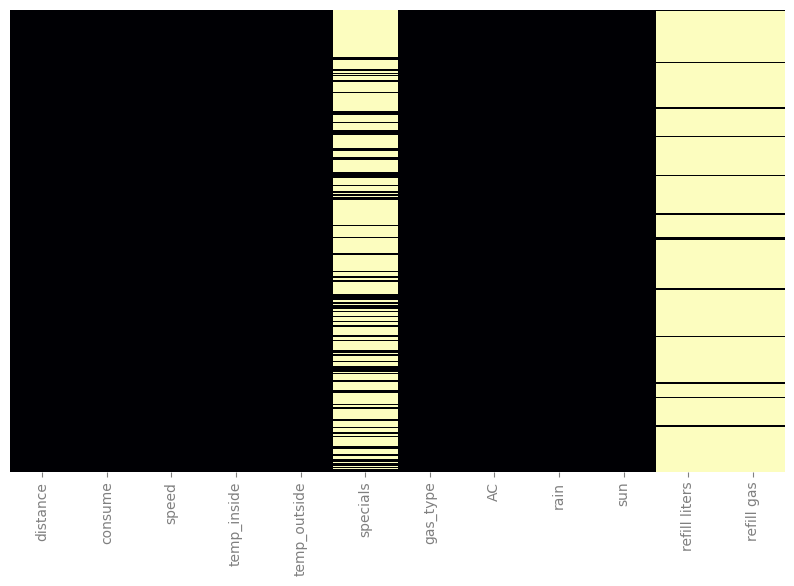

In [12]:
view_nan(df)

In [13]:
df['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC snow                1
half rain half sun     1
AC sun                 1
AC Sun                 1
ac rain                1
Name: specials, dtype: int64

The column `specials` don't bring any new information and can be dropped.

In [14]:
df.drop('specials', axis=1, inplace=True)

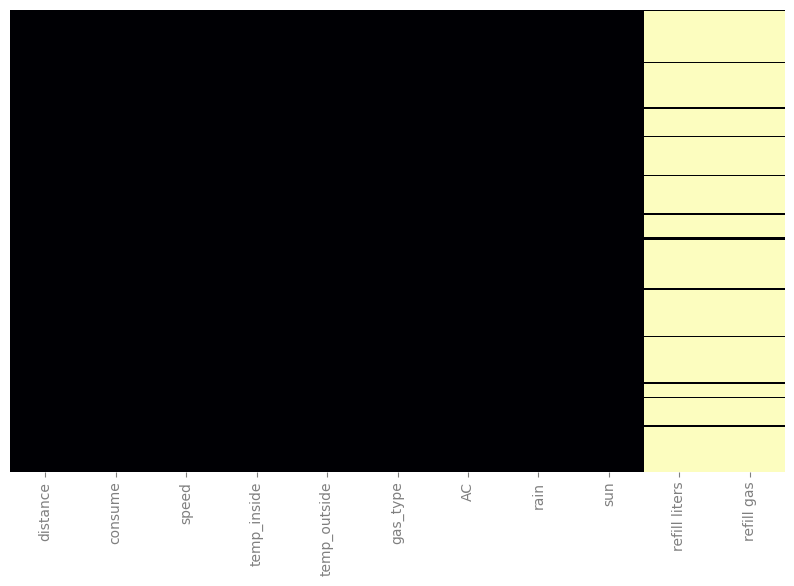

In [15]:
view_nan(df)

In [16]:
df['refill liters'].value_counts()

45.0    2
37.7    2
39.0    2
37.6    1
38.0    1
38.3    1
10.0    1
41.0    1
37.0    1
37.2    1
Name: refill liters, dtype: int64

Fuel Consumption (L) = (Distance (km)/100) × Consumption (L/100km)

In [17]:
# Calculate fuel consumption in liters
df['calculated_refill_liters'] = (df['distance'] / 100) * df['consume']

# Replace NaN values in 'refill liters' with calculated values
df['refill liters'].fillna(df['calculated_refill_liters'], inplace=True)

In [18]:
df[['gas_type', 'refill gas']][df['refill gas'].notna()]

,gas_type,refill gas
0,E10,E10
44,SP98,SP98
82,SP98,SP98
106,SP98,SP98
139,E10,E10
171,E10,E10
191,SP98,SP98
192,SP98,SP98
234,E10,E10
274,SP98,SP98


In [19]:
df.drop(['calculated_refill_liters', 'refill gas'], axis=1, inplace=True)

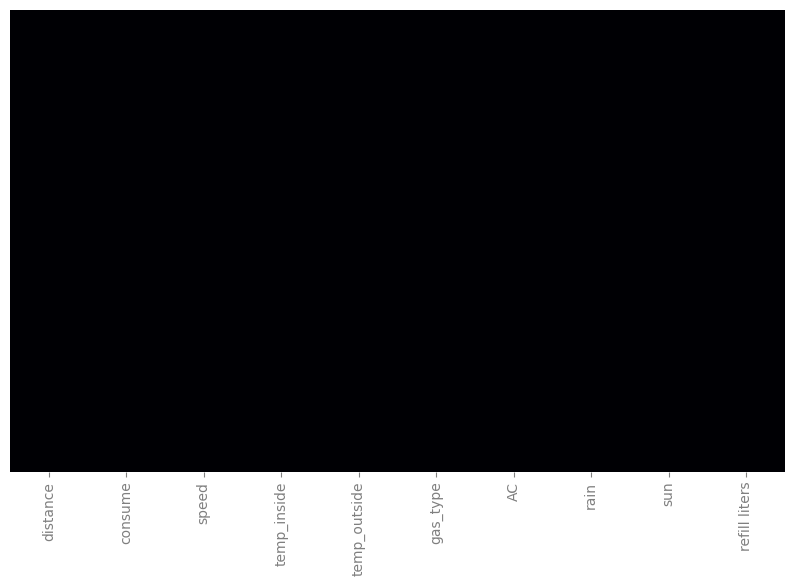

In [20]:
view_nan(df)

### Data Visualization
#### Which gas type has higher fuel consumption?

In [21]:
pd.pivot_table(data=df, index = df['gas_type'])

,AC,consume,distance,rain,refill liters,speed,sun,temp_inside,temp_outside
gas_type,,,,,,,,,
E10,0.043750,4.931250,21.096250,0.100000,2.209746,43.506250,0.075000,21.920650,10.11875
SP98,0.100877,4.899123,18.639912,0.140351,2.067395,40.820175,0.087719,21.937313,12.22807


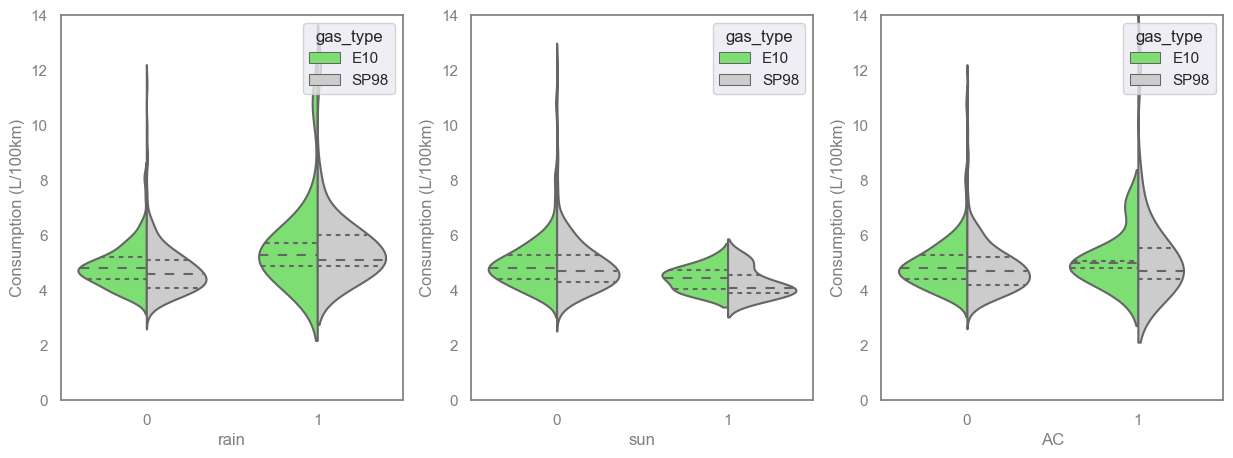

In [78]:
# Plot the consume

data = df[['consume', 'rain', 'sun', 'AC', 'gas_type']]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor = 'none')

sns.set_theme(style="dark")

for i, col in enumerate(['rain', 'sun', 'AC']):
   
    ax = axes[i]
    ax.set_facecolor('none')

    sns.violinplot(data=data,
                   x=col,
                   y='consume',
                   hue='gas_type',
                   split=True,
                   inner='quart',
                   fill=False,
                   palette={'E10': '#6EF161', 'SP98': '.8'},
                   ax=ax)
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.spines['right'].set_color('grey')
    ax.tick_params(colors = 'grey')
    ax.xaxis.label.set_color('grey')
    ax.set_ylabel('Consumption (L/100km)')
    ax.yaxis.label.set_color('grey')
    ax.set_ylim(0, 14)

        

# Show the figure
plt.show();

In all the cases the gas consumption for E10 is bigger than for SP98

### Statistics

In [23]:
# Check the normality of the samples

sample_SP98 = df['consume'][df['gas_type'] == 'SP98']
sample_E10 = df['consume'][df['gas_type'] == 'E10']

In [24]:
stat_SP98, p_value_SP98 = shapiro(sample_E10)
stat_E10, p_value_E10 = shapiro(sample_E10)

# Check the p-values
if p_value_SP98 > 0.05:
    print("sample_SP98 is likely normally distributed.")
else:
    print("sample_SP98 is not normally distributed.")

if p_value_E10 > 0.05:
    print("sample_E10 is likely normally distributed.")
else:
    print("sample_E10 is not normally distributed.")

sample_SP98 is not normally distributed.
sample_E10 is not normally distributed.


In [25]:
# Compare the samples with the Z-test

sample_SP98_mean = np.mean(sample_SP98)
sample_E10_mean = np.mean(sample_E10)

# Population standard deviation ('pop_std')
pop_std = df['consume'].std()

# Sample sizes ('n1' and 'n2')
n1 = len(sample_SP98)
n2 = len(sample_E10)

# Calculate the standard error of the difference between means
std_error_diff = np.sqrt((pop_std**2 / n1) + (pop_std**2 / n2))

# Calculate the Z-score
z_score = (sample_SP98_mean - sample_E10_mean) / std_error_diff

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(np.abs(z_score)))

# Print the Z-score and p-value
print("Z-score:", z_score)
print("Two-tailed p-value:", p_value)

# Compare the p-value with your significance level to make a decision
if p_value < 0.05:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to claim that the means are significantly different.")

Z-score: -0.30151706287537294
Two-tailed p-value: 0.7630202407608626
Fail to reject the null hypothesis: There is not enough evidence to claim that the means are significantly different.


In [26]:
# Standarize the samples

combined_data = np.concatenate((sample_SP98, sample_E10), axis=0)

scaler = StandardScaler()

scaled_data = scaler.fit_transform(combined_data.reshape(-1, 1))

norm_sample_SP98 = scaled_data[:len(sample_SP98)]
norm_sample_E10 = scaled_data[len(sample_E10):]

In [27]:
# Compare the normalizer samples with the Student's T-test

statistic, p_value = ttest_ind(norm_sample_SP98, 
                                norm_sample_E10,
                                alternative='two-sided',
                                equal_var=False)

# Print the T-score and p-value
print("T-score:", statistic)
print("Two-tailed p-value:", p_value)

# Compare the p-value with your significance level to make a decision
if p_value < 0.05:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to claim that the means are significantly different.")

T-score: [1.44692812]
Two-tailed p-value: [0.14865632]
Fail to reject the null hypothesis: There is not enough evidence to claim that the means are significantly different.


## Create a model to clasify the gas type

In [79]:
# Turn gas type into categories

label_encoder = LabelEncoder()
df['gas_type_encoded'] = label_encoder.fit_transform(df['gas_type'])

In [80]:
df[['gas_type', 'gas_type_encoded']].value_counts()

gas_type  gas_type_encoded
SP98      1                   228
E10       0                   160
dtype: int64

In [33]:
# Divide the data

X = df[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'refill liters']]
y = df['gas_type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train and Evaluate Classification Models

In [37]:
models = {"dtc": DecisionTreeClassifier(),
          "rfc": RandomForestClassifier(),
          "svcr": SVC(kernel="rbf"),
          "svcl": SVC(kernel="linear"),
          "knc": KNeighborsClassifier(),
          "logr": LogisticRegression(),
          "adaboost": AdaBoostClassifier(),
          "gradient_boosting": GradientBoostingClassifier(),
          "naive_bayes": GaussianNB(),
          "mlp": MLPClassifier(),
          "bagging": BaggingClassifier(),
          "extra_trees": ExtraTreesClassifier(),
          "voting": VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()), ('rfc', RandomForestClassifier()), ('svc', SVC())]),
          "stacking": StackingClassifier(estimators=[('knc', KNeighborsClassifier()), ('logr', LogisticRegression()), ('svc', SVC())], final_estimator=DecisionTreeClassifier()),
          "sgd": SGDClassifier(),
          "nu_svc": NuSVC(),
          "linear_svc": LinearSVC(),
          "gaussian_process": GaussianProcessClassifier(),
          "lda": LinearDiscriminantAnalysis(),
          "qda": QuadraticDiscriminantAnalysis()}   

In [61]:
model_scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[model_name] = accuracy

In [63]:
sorted_data = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
sorted_data

{'bagging': 0.7051282051282052,
 'dtc': 0.6923076923076923,
 'extra_trees': 0.6923076923076923,
 'gradient_boosting': 0.6666666666666666,
 'voting': 0.6538461538461539,
 'rfc': 0.6410256410256411,
 'adaboost': 0.6410256410256411,
 'gaussian_process': 0.6282051282051282,
 'naive_bayes': 0.6025641025641025,
 'knc': 0.5769230769230769,
 'qda': 0.5769230769230769,
 'logr': 0.5512820512820513,
 'stacking': 0.5512820512820513,
 'lda': 0.5512820512820513,
 'sgd': 0.5384615384615384,
 'svcr': 0.5256410256410257,
 'mlp': 0.5256410256410257,
 'svcl': 0.5128205128205128,
 'nu_svc': 0.5,
 'linear_svc': 0.5}

### Trying to improve the accuracy of the models using grid search for parametters

    'bagging': 0.7051282051282052,
    'dtc': 0.6923076923076923,
    'extra_trees': 0.6923076923076923

In [67]:
param_grid = {'base_estimator': [DecisionTreeClassifier()],  
              'n_estimators': [10, 50, 100],
              'max_samples': [0.5, 0.7, 1.0],
              'max_features': [0.5, 0.7, 1.0],
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}

bagging_classifier = BaggingClassifier()

grid_search = GridSearchCV(bagging_classifier, param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Parameters: {best_params}\nAccuracy Score: {best_score}')

Parameters: {'base_estimator': DecisionTreeClassifier(), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}
Accuracy Score: 0.6678491411501121


In [69]:
extra_trees_param_grid = {'n_estimators': [50, 100, 150],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [None, 10, 20],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 4],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'bootstrap': [True, False],
                          'class_weight': [None, 'balanced', 'balanced_subsample']}

extra_trees_classifier = ExtraTreesClassifier()

grid_search = GridSearchCV(extra_trees_classifier, extra_trees_param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Parameters: {best_params}\nAccuracy Score: {best_score}')

Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy Score: 0.7031989046552153


In [70]:
decision_tree_param_grid = {'criterion': ['gini', 'entropy'],
                            'splitter': ['best', 'random'],
                            'max_depth': [None, 10, 20, 30],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4],
                            'max_features': [None, 'auto', 'sqrt', 'log2']}
    

dtc_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dtc_classifier, decision_tree_param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Parameters: {best_params}\nAccuracy Score: {best_score}')

Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy Score: 0.6839058999253175


### Train the model with all the dataset

In [72]:
classifier = BaggingClassifier()
classifier.fit(X, y)

BaggingClassifier()

In [81]:
# Save the model and the label encoder

joblib.dump(label_encoder, '../model/label_encoder.pkl')
joblib.dump(classifier, '../model/classifier.pkl')

['../model/classifier.pkl']

### Test the model with random data

In [87]:
X_new = X.head(25)

In [89]:
# Change randomly the values

display(X_new.head(2))

for column in X_new.columns:
    X_new[column] = np.random.permutation(X_new[column])

display(X_new.head(2))

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
0,12.4,4.7,40,21.5,6,0,0,0,0.6018
1,4.9,4.7,38,21.5,14,0,0,0,0.5546


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
0,25.9,4.5,30,21.5,3,0,0,0,0.6160
1,12.4,5.5,36,21.5,13,0,0,0,0.6018


In [93]:
# Make predictions using the trained model

predictions = classifier.predict(X_new)
predictions

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0], dtype=int8)

In [92]:
decoded_predictions = label_encoder.inverse_transform(predictions)
decoded_predictions

array(['E10', 'E10', 'E10', 'SP98', 'E10', 'SP98', 'SP98', 'E10', 'E10',
       'E10', 'E10', 'SP98', 'E10', 'E10', 'SP98', 'SP98', 'SP98', 'E10',
       'E10', 'E10', 'E10', 'E10', 'E10', 'SP98', 'E10'], dtype=object)